# Seaborn examples in Julia

The Seaborn data visualization library in Python makes exquisite plots, but the documentation for using this package (Seaborn.jl) in Julia is limited, and not all of the functions have been exported. Here, we replicate examples a Python gallery of Seaborn-generated plots (http://seaborn.pydata.org/examples/) in Julia, and provide some observations to make it easier to adapt other Seaborn plots for use in Julia.

First, you have to install Seaborn in Python from the terminal, using the command:
pip install seaborn

There are some alternatives, detailed here: https://seaborn.pydata.org/installing.html

In [1]:
using Seaborn
using PyPlot
using PyCall
@pyimport seaborn as sns
using StatsBase
using Pandas
using DataFrames
using Distributions

In [2]:
#Run this if you want crisp vector graphics, but a slower notebook.
#We will use this for most plots, but disable it for plots with a large number of points,
#to control the notebook size.
PyPlot.svg(true);

*** 
The plots below make use of Julia-generated data directly, so that we don't need to deal with Pandas dataframes to generate them. Below, we will discuss examples where the plot-generating call requires a Pandas dataframe, and how we can deal with these. We use an explicit call to Seaborn to make our figures look exactly like those in the Python examples.

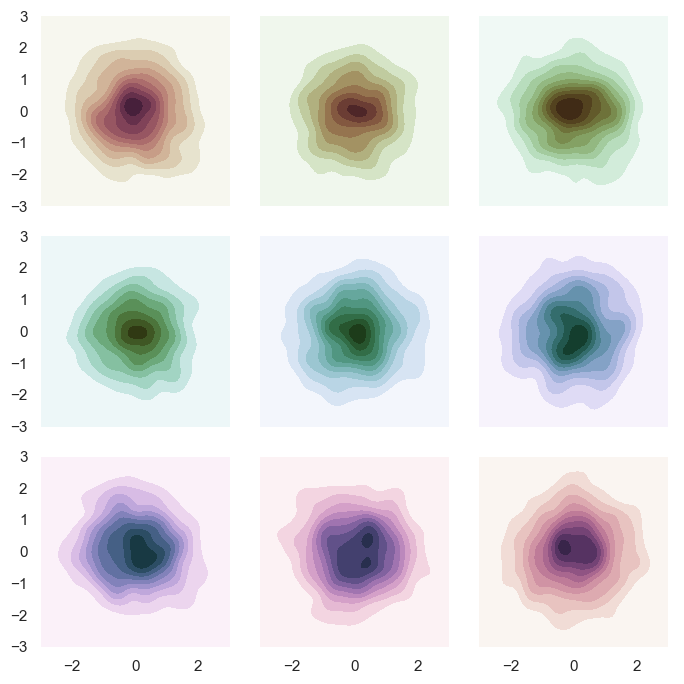

In [3]:
sns.set(style="dark")

#set up figure axes with a 3x3 grid and shared axes
fig, ax = subplots(3,3,figsize=(7, 7), sharex = true,sharey=true)

#loop over the axes
for i in 1:3
    for j in 1:3
    
      #generate a colour palette for each iteration
      cmap = sns.cubehelix_palette(start=((i-1)*3+j)/3, light=1, as_cmap=true)
      #generate a kernal density plot for random data, coloured by the current palette
      kdeplot(randn(1000),randn(1000), cmap=cmap, shade = true, cut=5, ax=ax[i,j])
      #set the axes bounds
      ax[i,j][:set](xlim=(-3, 3), ylim=(-3, 3))
    end
end

#tweak the layout
sns.despine(left=true, bottom=true)
tight_layout();

---
As can be seen below, the typical Python commands for changing axis formatting, eg.
```python
ax.axhline(...)
```
should be replaced by
```julia
ax[:axhline](...)
```
which is a general rule of thumb for adapting these commands from the Python API to Julia.

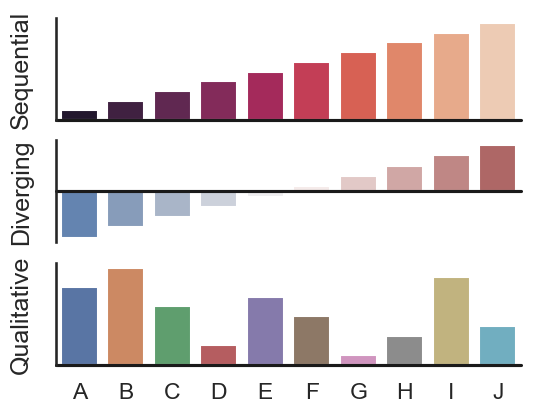

In [4]:
sns.set(style="white", context="talk")

xlabels = "ABCDEFGHIJ"
# generate xlabels "A" to "J"
x = [xlabels[i:i] for i in 1:length(xlabels)]
#generate sequential data
y1 = collect(1:10)
y2 = y1.-5.5
#randomly resample sequential data
y3= Distributions.sample(y1,length(y1),replace=false)

#set up 3x1 figure and name axes accordingly
fig, (ax1, ax2,ax3) = subplots(3,1,figsize=(6,4.5), sharex=true)

#plot each subplot, and format axes as desired
barplot(x, y1, palette="rocket",ax=ax1)
ax1[:axhline](0, color="k", clip_on=false)
ax1[:set_yticklabels]("")
ax1[:set_ylabel]("Sequential")

barplot(x, y2, palette="vlag",ax=ax2)
ax2[:axhline](0, color="k", clip_on=false)
ax2[:set_yticklabels]("")
ax2[:set_ylabel]("Diverging")

barplot(x=x, y=y3, palette="deep", ax=ax3)
ax3[:axhline](0, color="k", clip_on=false)
ax3[:set_yticklabels]("")
ax3[:set_ylabel]("Qualitative")

#tweak overall plot
sns.despine(bottom=true);

---
This example uses a 2 dimensional set of axes to create a grid, and we use a loop to remove the y axis labels for simplicity.

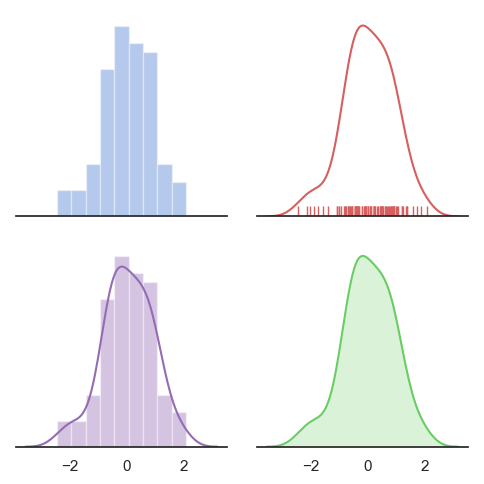

In [5]:
#generate random data
dat=randn(100)

sns.set(style="white", palette="muted", color_codes=true)

#2x2 plot
fig, ax = subplots(2,2, figsize=(5, 5), sharex = true)

#draw each subplot on the indicated axes
distplot(dat, kde=false, color="b",ax=ax[1,1])
distplot(dat, hist=false, rug=true, color="r",ax=ax[1,2])
distplot(dat, color="m", ax=ax[2,1])
distplot(dat, hist=false, color="g", kde_kws=Dict("shade"=> true), ax=ax[2,2])

#loop through and remove y-axis labels from each subplot
for i in 1:2
    for j in 1:2
        ax[i,j][:set_yticklabels]("")
    end
end

sns.despine(left=true)
tight_layout();

---
Now, we come to an example of a function that was not imported into the Julia package, and which required a Pandas dataframe to run. Below is an example using a call to Seaborn, with the data loaded into a Pandas dataframe.

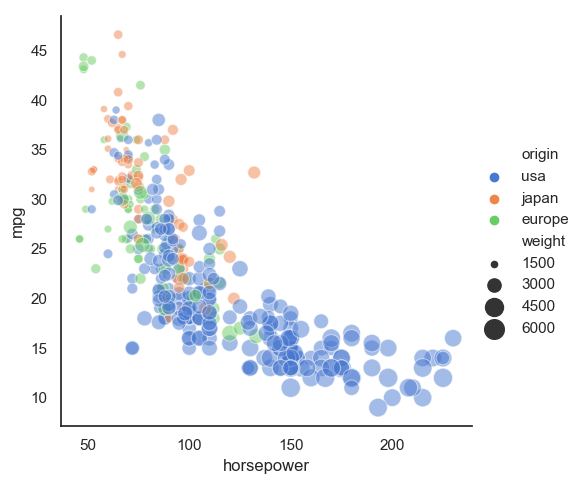

In [6]:
mpg_data = load_dataset("mpg");

sns.relplot(x="horsepower", y="mpg", hue="origin",size="weight", 
    sizes=(20,200), alpha=.5, palette="muted", data=mpg_data);

---
However, we would like to be able to use Julia dataframes to generate this plot, as this is the data format we would likely be working with in Julia. One option would be to use the following command, which converts a Julia dataframe (df) into a Pandas dataframe (pd) compatible with the function above:
```julia
pd = Pandas.DataFrame(df);
```
Alternatively, we can define our own custom function, which takes vectors x,y and, optionally, vectors that control the size and colour of the plotted points. As shown below, we can use this function on components of a Julia dataframe directly, to obtain an exact replica of the original plot.

In [7]:
function relplot(x,y;col=nothing,size=nothing,alpha=1.0, palette="muted", sizes = (20,100))
    
    #set colour string to empty if none input
    if col==nothing
        col = ["" for i in 1:length(x)]
    end
    #set size to 1 if none input
    if size==nothing
        size = ones(length(x))
    end
    
    #convert input vectors to a Julia dataframe
    df = DataFrames.DataFrame(x=x,y=y,col=col,size=size)
    #convert Julia dataframe to Pandas
    pd = Pandas.DataFrame(df)
    
    #call the Python version of relplot, with a Pandas dataframe as input
    sns.relplot(x="x", y="y", hue="col",size="size", sizes=sizes, alpha=alpha, palette=palette, data=pd)
    
end;

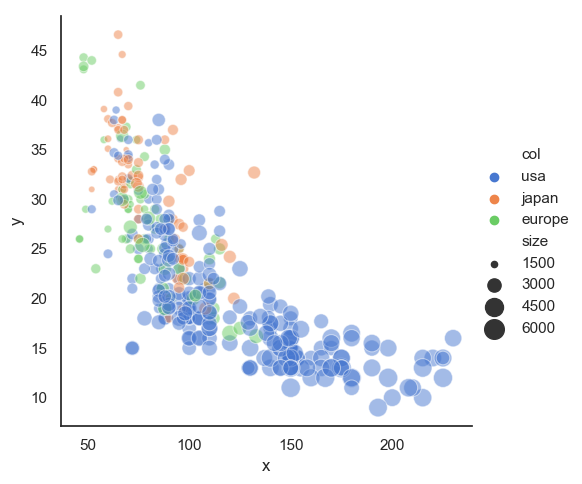

In [8]:
#first convert the Pandas dataframe to a Julia dataframe
julia_mpg=(DataFrames.DataFrame(mpg_data))

#pass the appropriate variables to our function
relplot(julia_mpg[:horsepower],julia_mpg[:mpg],col=julia_mpg[:origin],size=julia_mpg[:weight], 
    alpha=0.5, sizes=(20,200));

---
In some case, as in the case below, the function can accept either a Pandas dataframe or a set of vectors, and it often isn't obvious when.

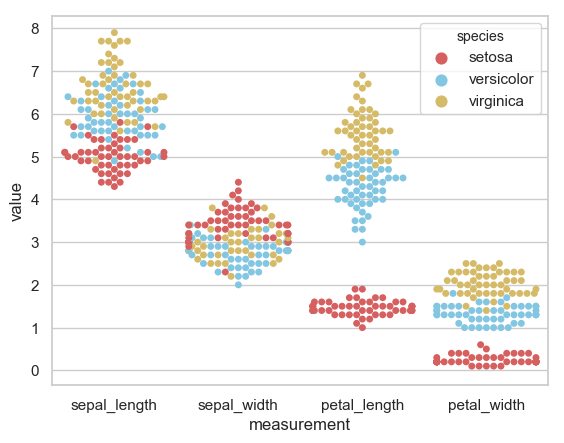

In [9]:
sns.set(style="whitegrid", palette="muted")

# Load the example iris dataset
iris = load_dataset("iris")

#"Melt" the dataset to "long-form" or "tidy" representation
iris_melt = Pandas.melt(iris, "species", var_name="measurement")

#Draw a categorical scatterplot to show each observation
swarmplot(x="measurement", y="value", hue="species",
         palette=["r", "c", "y"], data=iris_melt);

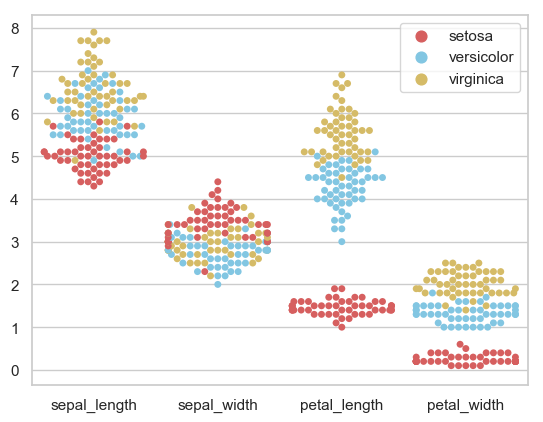

In [10]:
julia_iris_melt=DataFrames.DataFrame(iris_melt)

swarmplot(x=julia_iris_melt[:measurement], y=julia_iris_melt[:value], hue=julia_iris_melt[:species],
           palette=["r", "c", "y"]);

---
The examples below constitute the majority of the rest of the Seaborn examples in the Python gallery http://seaborn.pydata.org/examples/, and should make reproduction of similar plots in Julia trivial. 

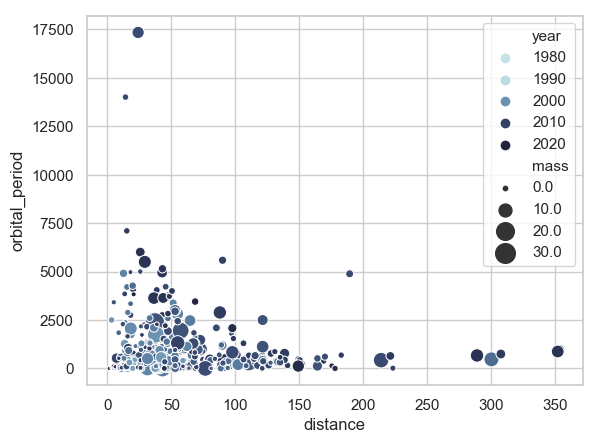

In [11]:
planets = load_dataset("planets")

#define the colour palette
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=true)

#scatter plot of distance by orbital period, coloured by
sns.scatterplot(x="distance", y="orbital_period",
                   hue="year", size="mass",
                   palette=cmap, sizes=(10, 200),
                   data=planets);

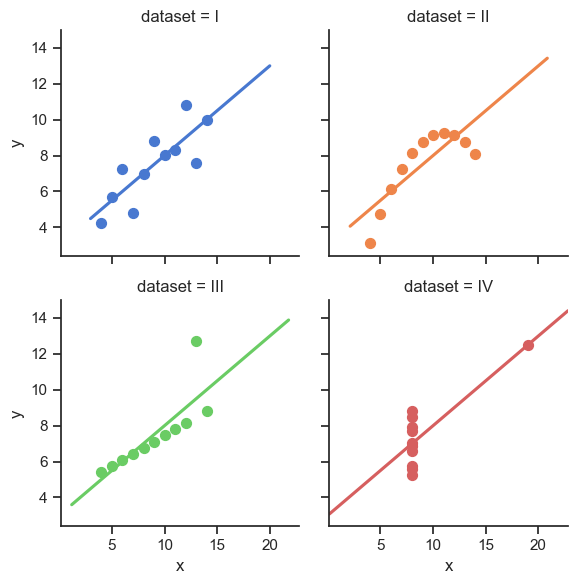

In [12]:
sns.set(style="ticks")

# load the Anscombe's quartet dataset
df = load_dataset("anscombe")

# Show the results of a linear regression within each dataset
lmplot(x="x", y="y", col="dataset", hue="dataset", data=df,
           col_wrap=2, ci=nothing, palette="muted", height=3,
           scatter_kws=Dict("s"=> 50, "alpha"=> 1));

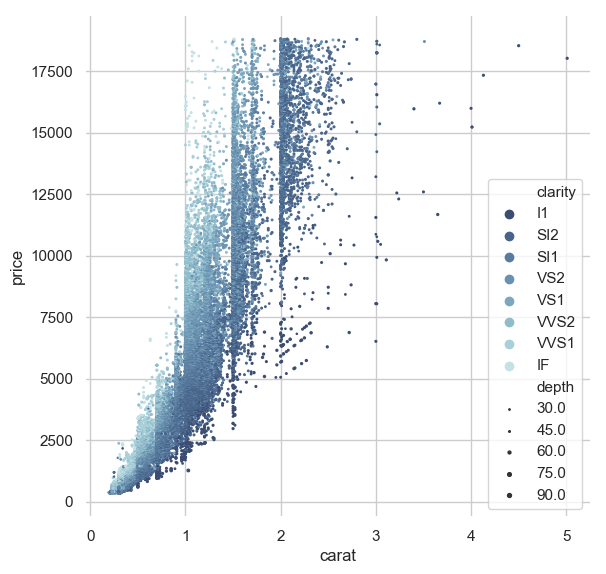

In [13]:
PyPlot.svg(false); #Disabling svg for this plot, to keep the size of this notebook in check.

sns.set(style="whitegrid")

diamonds = load_dataset("diamonds")

# scatterplot with dot size and colour determined by depth and clarity
f, ax = subplots(figsize=(6.5, 6.5))
sns.despine(f, left=true, bottom=true)
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="carat", y="price",
                hue="clarity", size="depth",
                palette="ch:r=-.2,d=.3_r",
                hue_order=clarity_ranking,
                sizes=(1, 8), linewidth=0,data=diamonds,
                ax=ax);

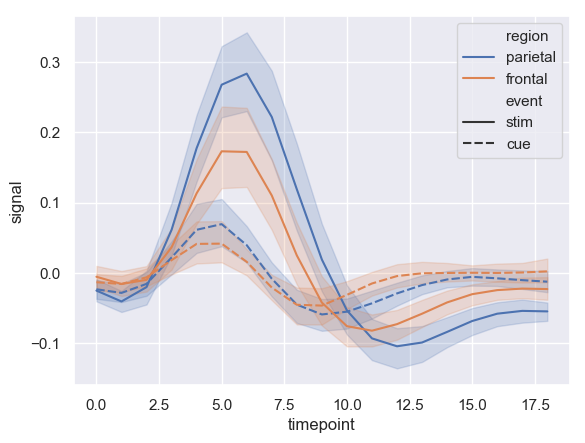

In [14]:
PyPlot.svg(true);

sns.set(style="darkgrid")

fmri = load_dataset("fmri")

#plot the signal over time for different events and regions, with the 95% CI indicated
sns.lineplot(x="timepoint", y="signal",
            hue="region", style="event",
            data=fmri);

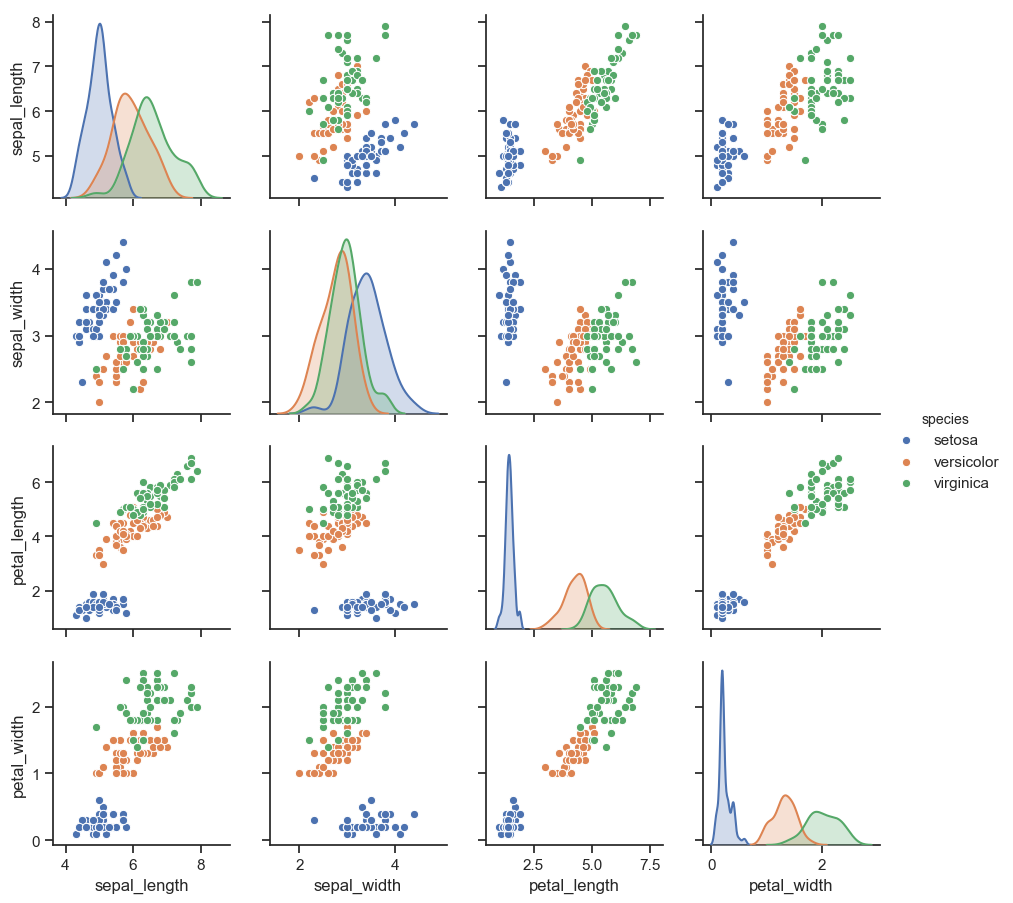

In [15]:
sns.set(style="ticks")

df = load_dataset("iris")

#pair plot for each numerical variable, coloured by categorical variable species.
pairplot(df, hue="species",height = 2.3);

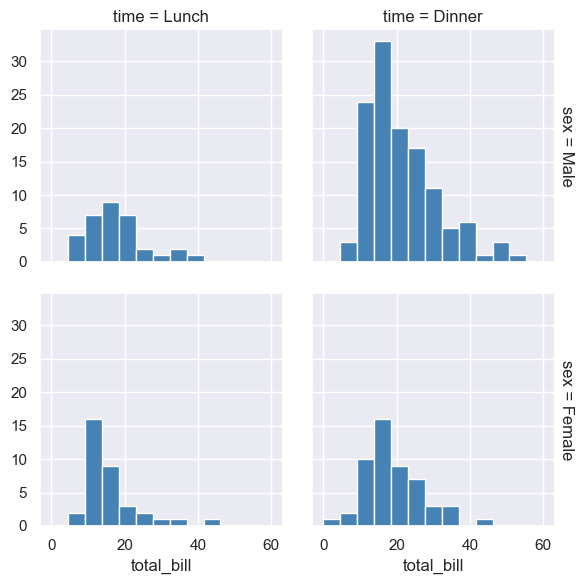

In [16]:
sns.set(style="darkgrid")

tips = load_dataset("tips")

#set up a faceted grid
g = sns.FacetGrid(tips, row="sex", col="time", margin_titles=true)
#define bins
bins = [j for j in 0:60/13:60]

#draw histograms onto each plot, categorised by sex and time
g[:map](plt[:hist], "total_bill", color="steelblue", bins=bins);

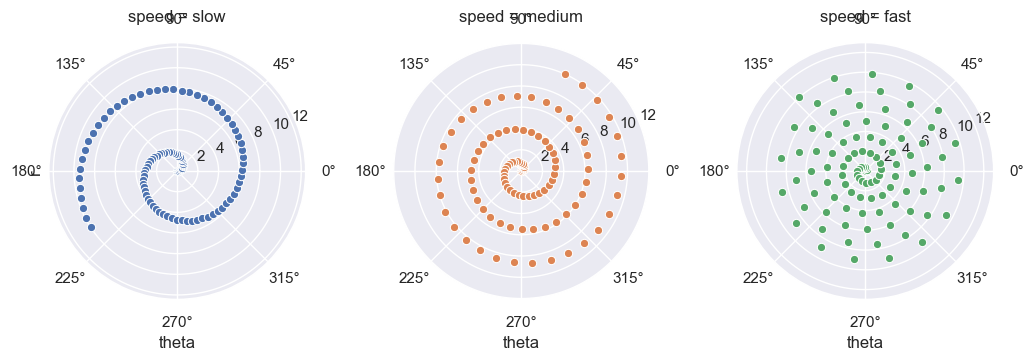

In [17]:
sns.set()

# generate a radial datast
r = 0:0.1:10
df = Pandas.DataFrame(Dict("r"=> r, "slow"=> r, "medium"=> 2 * r, "fast" => 4 * r))

#convert the dataframe to long-form format
df = Pandas.melt(df, id_vars=["r"], var_name="speed", value_name="theta")

# set up a grid of polar axes
g = sns.FacetGrid(df, col="speed", hue="speed",
                 subplot_kws=Dict("projection"=>"polar"), height=3.5,
                 sharex=false, sharey=false, despine=false)

# Draw a scatterplot onto each of the axes in the grid
g[:map](sns.scatterplot, "theta", "r");

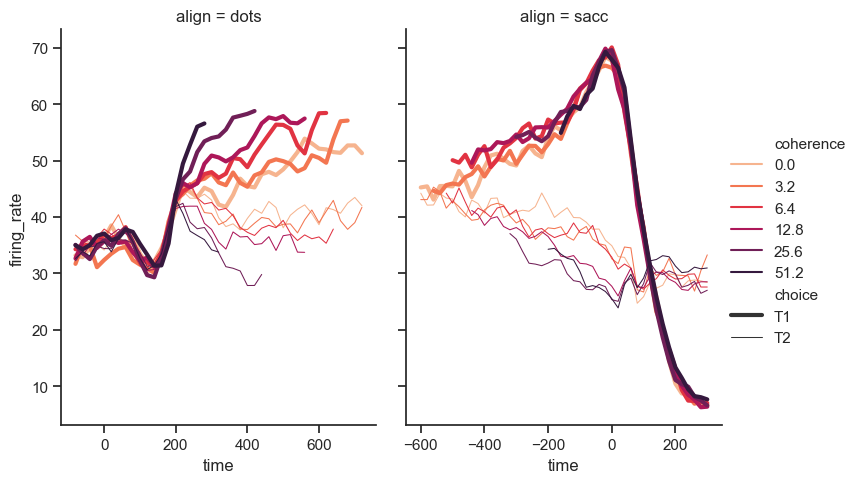

In [18]:
sns.set(style="ticks")

dots = load_dataset("dots")
dots

#define a palette across the facets
palette = sns.color_palette("rocket_r", 6)

#plot the lines for each group on a different facet, coloured by coherence and proportionate to choice
sns.relplot(x="time", y="firing_rate",
         hue="coherence", size="choice", col="align",
         size_order=["T1", "T2"], palette=palette,
           height=5, aspect=.75, facet_kws=Dict("sharex" =>false),
            kind="line", legend="full", data=dots);

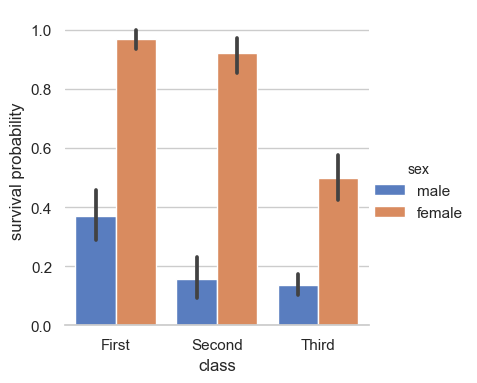

In [19]:
sns.set(style="whitegrid")

titanic = load_dataset("titanic")

# draw a nested barplot showing survival by class and sex
g = sns.catplot(x="class", y="survived", hue="sex", data=titanic,
                height=4, kind="bar", palette="muted")

g[:despine](left=true)
g[:set_ylabels]("survival probability");

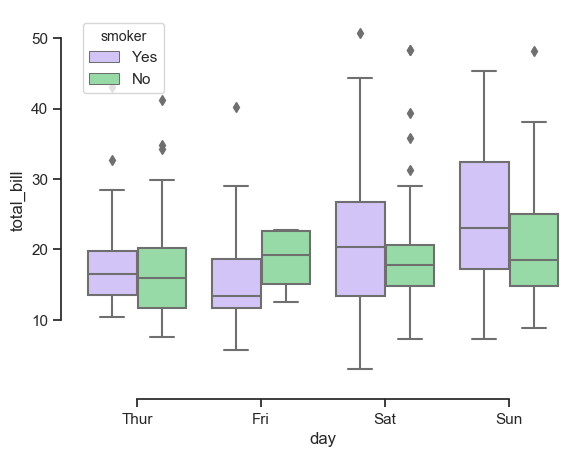

In [20]:
sns.set(style="ticks", palette="pastel")

# load the etips dataset
tips = load_dataset("tips")

# draw a nested boxplot to show the bill by day, separated by smokers
sns.boxplot(x="day", y="total_bill",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=true);

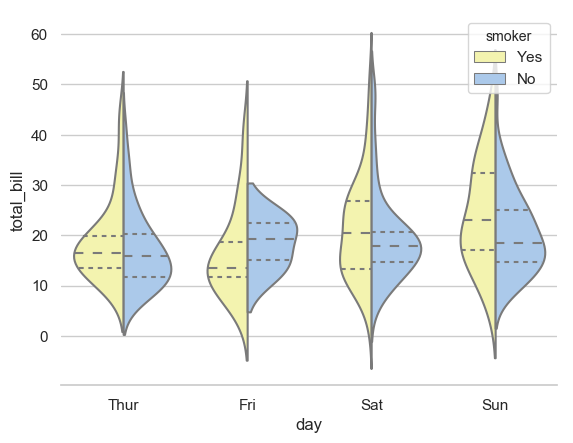

In [21]:
sns.set(style="whitegrid", palette="pastel", color_codes=true)

# load the tips dataset
tips = load_dataset("tips")

# draw a violin plot of the total bill for each day, split by smoker/nonsmoker
violinplot(x="day", y="total_bill", hue="smoker",
               split=true, inner="quart",
               palette=Dict("Yes"=> "y", "No"=> "b"),
               data=tips)
sns.despine(left=true);

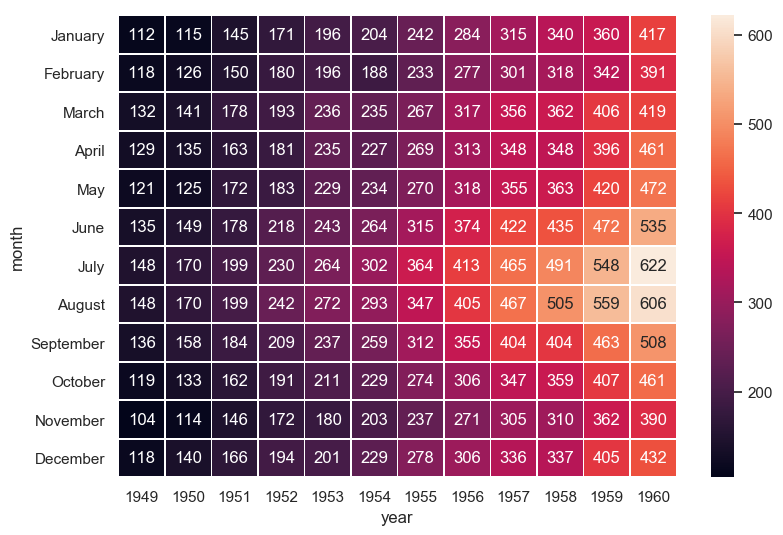

In [22]:
sns.set()

# load dataset and convert to longform
flights_long = load_dataset("flights")
flights = Pandas.pivot(flights_long, "month", "year", "passengers")

# draw a heatmap, showing the values in each box as text (annot=true)
f, ax = subplots(figsize=(9, 6))
sns.heatmap(flights, annot=true, fmt="d", linewidths=.5, ax=ax);

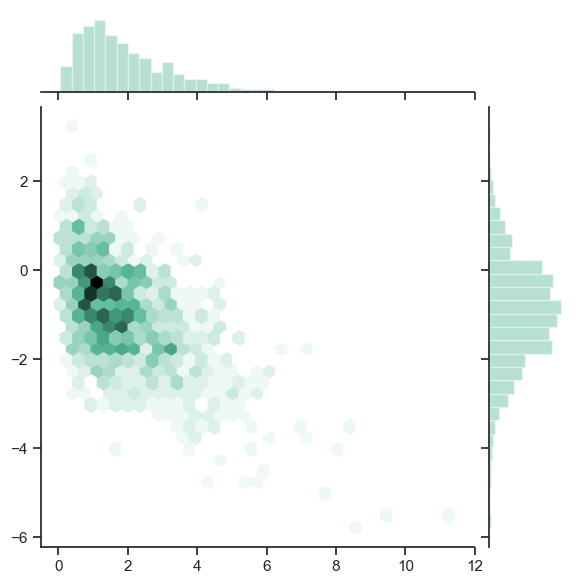

In [23]:
sns.set(style="ticks")

#generate x from a gamma distribution and x dependent on y
x = rand(Gamma(2,1), 1000)
y = -.5 * x + randn(1000)

#plot joint distribution with shading corresponding to density
jointplot(x, y, kind="hex", color="#4CB391");

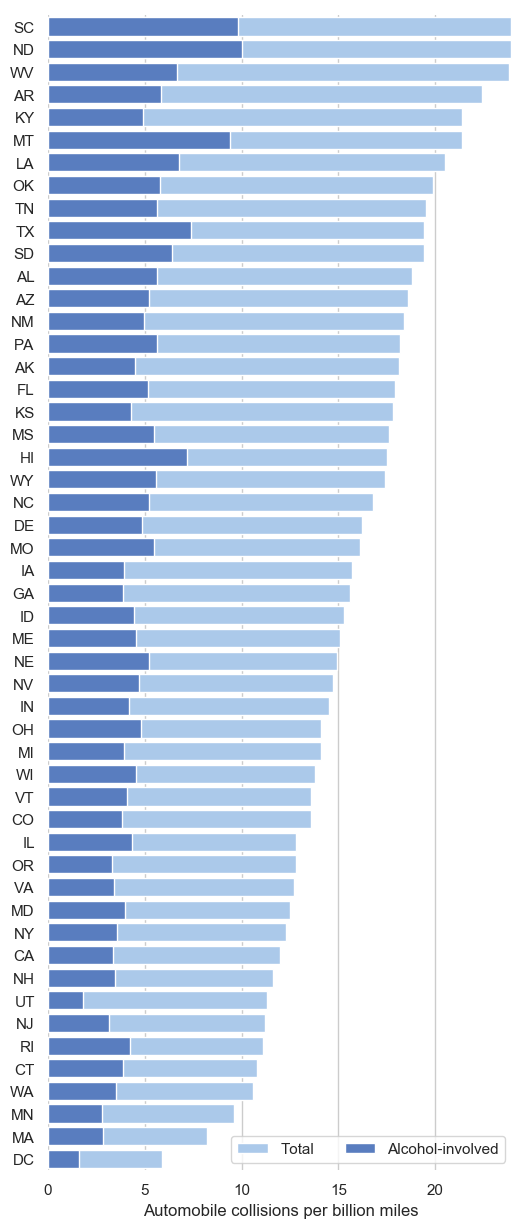

In [24]:
sns.set(style="whitegrid")

# Initialize the axes for the subplots
f, ax = subplots(figsize=(6, 15))

# load in the data - note the [:sort_values] replacing the Python .sort_values
crashes = sns.load_dataset("car_crashes")[:sort_values]("total", ascending=false)

# plot a bar including all crashes in each state
set_color_codes("pastel")
barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# superimpose those where alcohol was involved.
set_color_codes("muted")
barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# add legend and axis label
ax[:legend](ncol=2, loc="lower right", frameon=true)
ax[:set](xlim=(0, 24), ylabel="", xlabel="Automobile collisions per billion miles")
sns.despine(left=true, bottom=true);

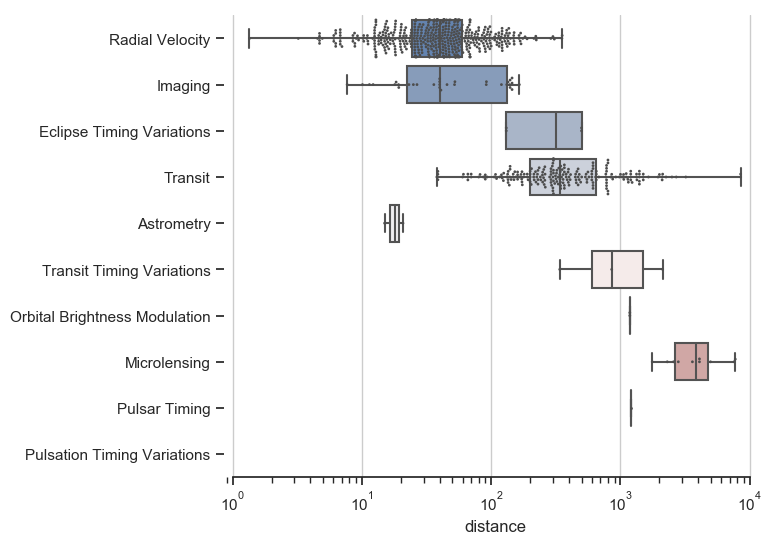

In [25]:
PyPlot.svg(false);

sns.set(style="ticks")

# Initialize the figure and set the axis scale to logarithmic
f, ax = subplots(figsize=(7, 6))
ax[:set_xscale]("log")

planets = load_dataset("planets")

# plot boxplots for orbital period
sns.boxplot(x="distance", y="method", data=planets,
            whis="range", palette="vlag")

# plot individual observations over the boxplot
sns.swarmplot(x="distance", y="method", data=planets,
              size=2, color=".3", linewidth=0)

# add a grid to the x-axis and alter the y-axis label
ax[:xaxis][:grid](true)
ax[:set](ylabel="")
sns.despine(trim=true, left=true);

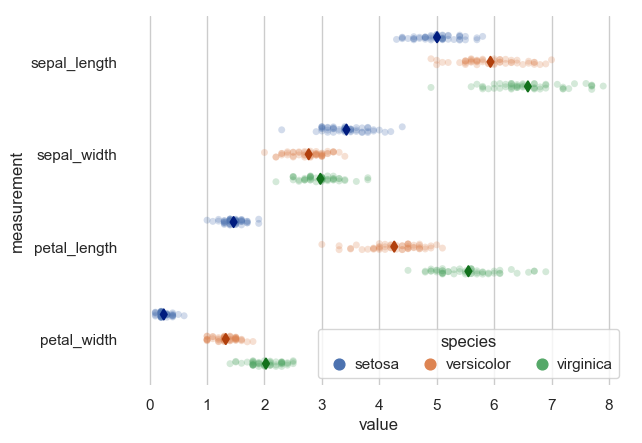

In [26]:
sns.set(style="whitegrid")
iris = load_dataset("iris")

# convert data to "long-form"
iris = Pandas.melt(iris, "species", var_name="measurement")

# initialise figure
f, ax = subplots()
sns.despine(bottom=true, left=true)

# scatter plot for observations
stripplot(x="value", y="measurement", hue="species",
              data=iris, dodge=true, jitter=true,
             alpha=.25, zorder=1)

#show the conditional means for each group
pointplot(x="value", y="measurement", hue="species",
             data=iris, dodge=.532, join=false, palette="dark",
              markers="d", scale=.75, ci=nothing)

#set up the legend
handles, labels = ax[:get_legend_handles_labels]()
ax[:legend](handles[1:3], labels[1:3], title="species",
        handletextpad=0, columnspacing=1,
        loc="lower right", ncol=3, frameon=true);

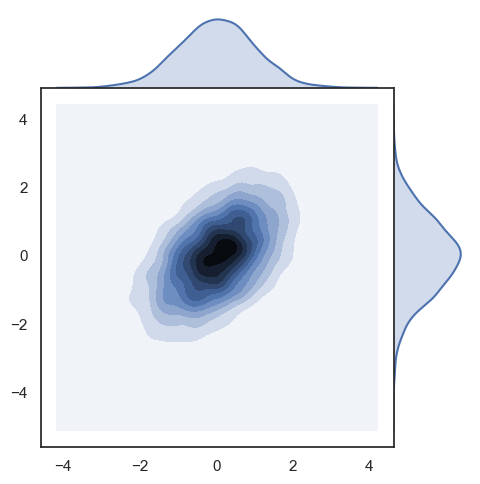

In [27]:
PyPlot.svg(true);

sns.set(style="white")

# generate correlated dataset
x1 = randn(5000)
x2 = x1 .* 0.577 .+ randn(5000);

# show the joint distribution using kernel density estimation
sns.jointplot(x1, x2, kind="kde", height=5, space=0);

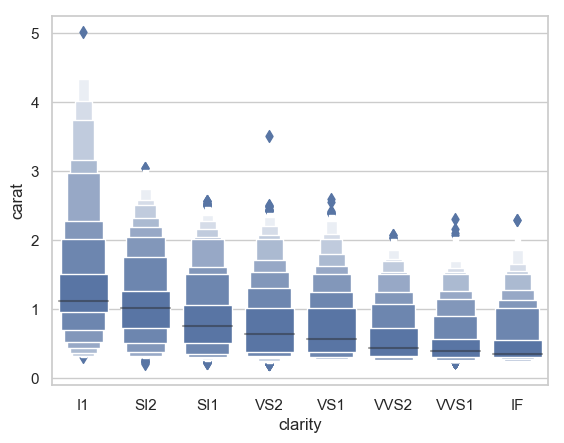

In [28]:
sns.set(style="whitegrid")

diamonds = load_dataset("diamonds")
#set clarity ranking order
clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]

#box plots ordered by the clarity ranking
sns.boxenplot(x="clarity", y="carat",
              color="b", order=clarity_ranking,
              scale="linear", data=diamonds);

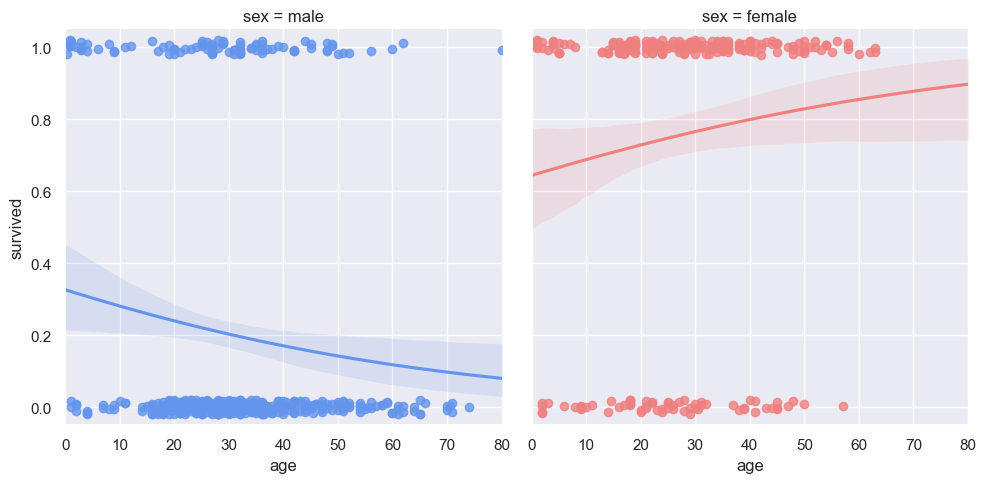

In [29]:
sns.set(style="darkgrid")

df = load_dataset("titanic")

# custom palette syntax for colouring by gender
pal = Dict("male"=>"#6495ED", "female"=>"#F08080")

# survival probably for each gender as a function of age, with 95% CI indicated
g=sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
               palette=pal, y_jitter=0.02, logistic=true)
g[:set](xlim=(0, 80), ylim=(-0.05, 1.05));

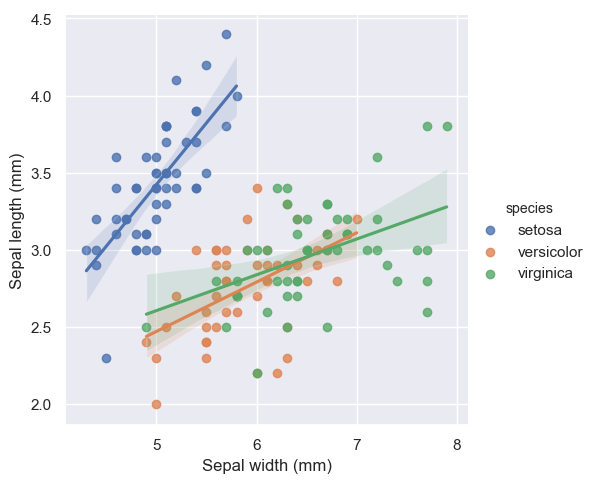

In [30]:
sns.set()

iris = load_dataset("iris")

# plot linear regression of sepal length vs width for each species, with the 95% CI indicated
g=lmplot(x="sepal_length", y="sepal_width", hue="species",
               truncate=true, height=5, data=iris)

# label the axes informatively
g[:set](ylabel="Sepal length (mm)", xlabel="Sepal width (mm)");

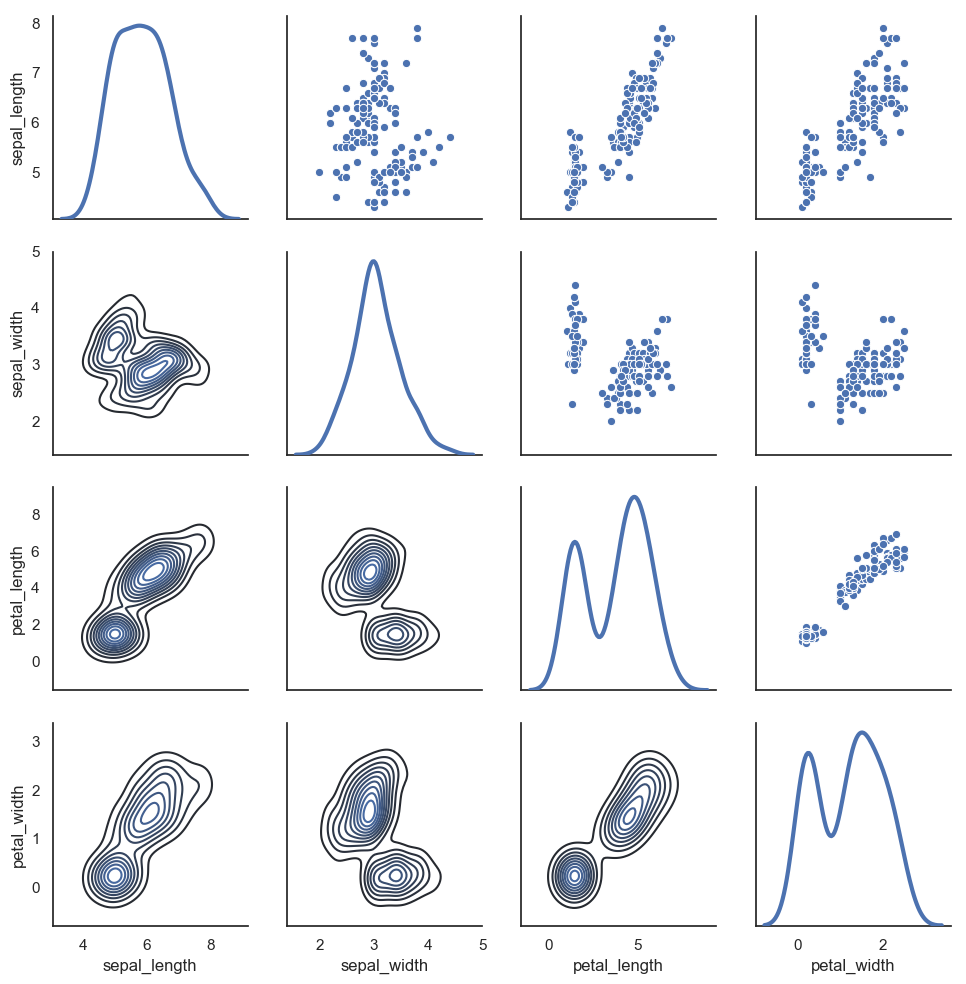

In [31]:
sns.set(style="white")

df = load_dataset("iris")

#generate a grid for all pairs of variables
g=sns.PairGrid(df, diag_sharey=false)
#generate plots for each region of the grid
g[:map_lower](sns.kdeplot)
g[:map_upper](sns.scatterplot)
g[:map_diag](sns.kdeplot, lw=3);

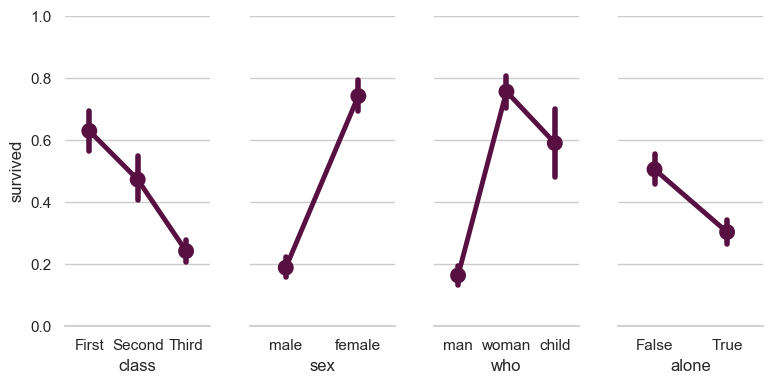

In [32]:
sns.set(style="whitegrid")

titanic = load_dataset("titanic")

# set up a grid to plot survival probability versus several variables
g = sns.PairGrid(titanic, y_vars="survived",
                 x_vars=["class", "sex", "who", "alone"],
                 height=4, aspect=.5)

# draw a plot on each grid plot
g[:map](sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
g[:set](ylim=(0, 1))
sns.despine(left=true);

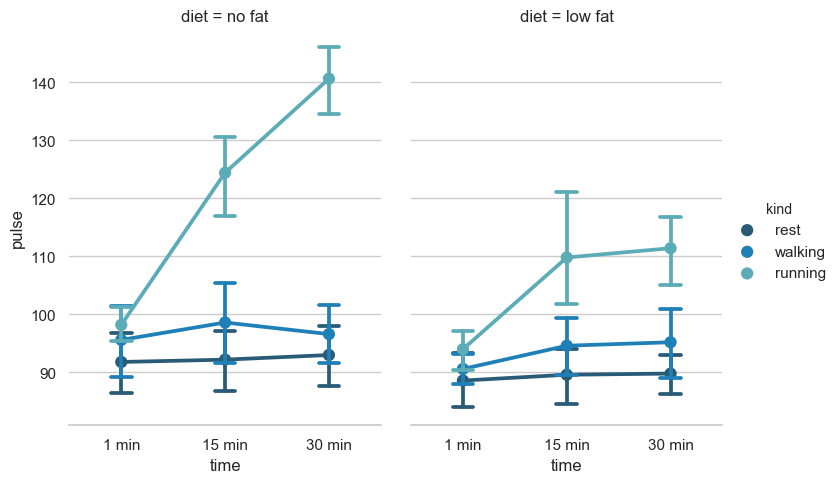

In [33]:
sns.set(style="whitegrid")

df = load_dataset("exercise")

# draw a pointplot to show pulse over time, as a function of three categorical factors
g = sns.catplot(x="time", y="pulse", hue="kind", col="diet",
                capsize=.2, palette="YlGnBu_d", height=5, aspect=.75,
                kind="point", data=df)
g[:despine](left=true);

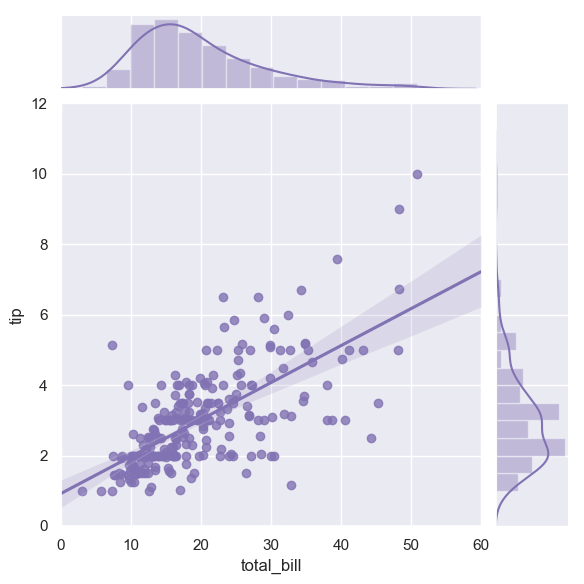

In [34]:
sns.set(style="darkgrid")

tips = load_dataset("tips")

#plot the distribution of total bill and tip, as well as a regression of one against the other
g = sns.jointplot("total_bill", "tip", data=tips, kind="reg",
                  xlim=(0, 60), ylim=(0, 12), color="m", height=6);

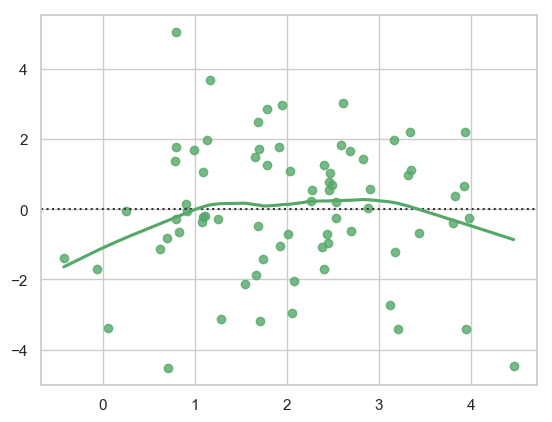

In [35]:
sns.set(style="whitegrid")

# generate a bivariate dataset where y~x
x= rand(Normal(2, 1), 75)
y =  1.5.* x .+ rand(Normal(0, 2), 75) .+2

# fit a linear model and plot the residuals
sns.residplot(x, y, lowess=true, color="g");

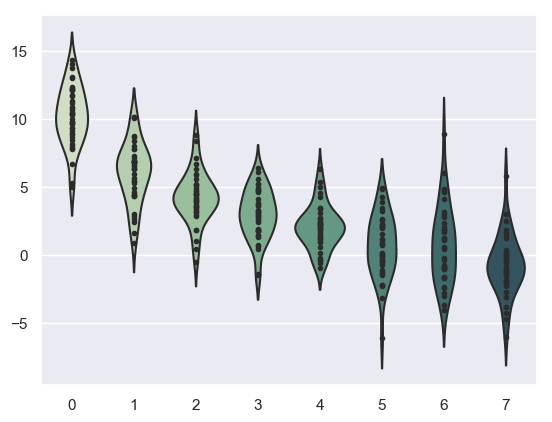

In [36]:
sns.set()

# create a 2 dimensional random dataset
d = randn(40,8).*2 .+ log.([1:8;]') .* -5 .+ 10

# generate a custom palette with 8 colours
pal = sns.cubehelix_palette(8, rot=-.5, dark=.3)

# show violin plot for each variable, with dots for each data point
sns.violinplot(data=d, palette=pal, inner="points");

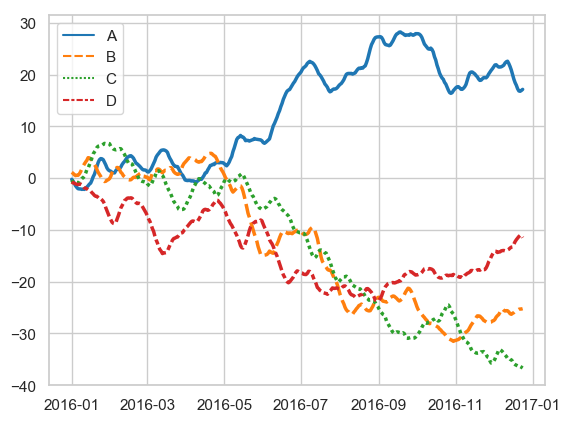

In [37]:
using RollingFunctions

sns.set(style="whitegrid")

#generate random walk
prevalues = cumsum(randn(365, 4),dims = 1)
values = zeros(365-6,4)

# generate a rolling mean from a sliding window
for i in 1:4
    values[:,i] .= rollmean(prevalues[:,i],7)
end

#generate a date range and create a dataframe with 4 walks
dates = Pandas.date_range("1 1 2016", periods=365-6, freq="D")
data = Pandas.DataFrame(values, dates, columns=["A", "B", "C", "D"])

#plot random walks over time
sns.lineplot(data=data, palette="tab10", linewidth=2.5);